## Post-process a finetuned LLM

Test and upload a finetuned language model

## Setup

In [1]:
import transformers
import torch
import tensorflow as tf

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
!nvidia-smi

Sat Jul  1 02:26:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA H100 PCIe    On   | 00000000:06:00.0 Off |                    0 |
| N/A   44C    P0    52W / 350W |      3MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
free_in_GB = int(torch.cuda.mem_get_info()[0] / 1024**3)
max_memory = f"{free_in_GB-2}GB"
n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}
print("max memory: ", max_memory)

max memory:  {0: '76GB'}


## Loss curve

In [4]:
# assumes you have already run `sft-instruction-llm.py`
# see documentation and comments therein for details
# recommendation: run `sft-instruction-llm.py` directly from the terminal
# by default, the mpt-7b instruction model demo is used


# load the train loss from the finetuning events log
train_steps = []
train_loss = []
path_to_events_file = "./results/runs/Jun30_21-22-46_209-20-158-153/events.out.tfevents.1688160191.209-20-158-153.75529.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if "loss" in v.tag:
            train_loss.append(v.simple_value)
            train_steps.append(e.step)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


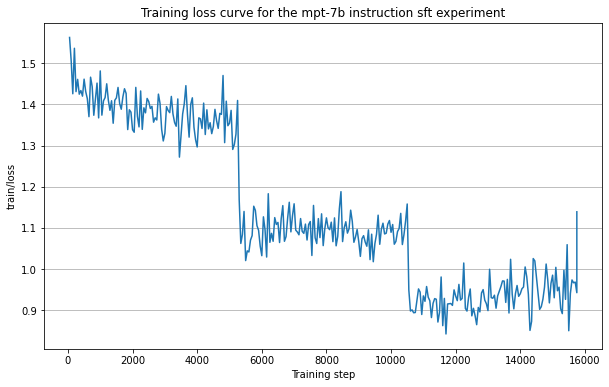

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss)
plt.title("Training loss curve for the mpt-7b supervised finetuning experiment")
plt.ylabel("train loss")
plt.xlabel("train step")
plt.grid(which="major", axis="y")
plt.show()

With a supervised finetuned (sft) model in hand, we can test it on some basic prompts and then upload it to the Hugging Face hub either as a public or private model repo, depending on the use case.

In [7]:
# load assets

model_id = "results/checkpoint-15750"
# model_id = 'dfurman/mpt-7b-instruct-reproduction'

# mpt tokenizer load
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
# set mpt tokenizer default padding token
tokenizer.pad_token = "<|padding|>"
tokenizer.pad_token_id = tokenizer.encode("<|padding|>")[0]

# mpt llm load
config = transformers.AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# custom options
# config.attn_config['attn_impl'] = 'torch' # Default attention option
config.attn_config[
    "attn_impl"
] = "triton"  # Optional triton attention for improved latency
config.init_device = "cuda"  # For fast initialization directly on GPU!
config.max_seq_len = 4096  # (input + output) tokens can now be up to 4096
config.torch_dtype = "float16"  # Set float16 data type

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
)

config

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Instantiating an MPTForCausalLM model from /home/ubuntu/.cache/huggingface/modules/transformers_modules/mosaicml/mpt-7b/a78c1fa391580242211a2f516cf9ef10c86713c8/modeling_mpt.py
You are using config.init_device='cuda', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MPTConfig {
  "_name_or_path": "results/checkpoint-15750",
  "architectures": [
    "MPTForCausalLM"
  ],
  "attn_config": {
    "alibi": true,
    "alibi_bias_max": 8,
    "attn_impl": "triton",
    "attn_pdrop": 0,
    "attn_type": "multihead_attention",
    "attn_uses_sequence_id": false,
    "clip_qkv": null,
    "prefix_lm": false,
    "qk_ln": false,
    "softmax_scale": null
  },
  "auto_map": {
    "AutoConfig": "mosaicml/mpt-7b--configuration_mpt.MPTConfig",
    "AutoModelForCausalLM": "mosaicml/mpt-7b--modeling_mpt.MPTForCausalLM"
  },
  "d_model": 4096,
  "emb_pdrop": 0,
  "embedding_fraction": 1.0,
  "expansion_ratio": 4,
  "init_config": {
    "emb_init_std": null,
    "emb_init_uniform_lim": null,
    "fan_mode": "fan_in",
    "init_div_is_residual": true,
    "init_gain": 0,
    "init_nonlinearity": "relu",
    "init_std": 0.02,
    "name": "kaiming_normal_",
    "verbose": 0
  },
  "init_device": "cuda",
  "learned_pos_emb": true,
  "logit_scale": null,
  "max_seq_len":

## Basic instruction tests

In [8]:
# format for instruction prompts from mpt documentation

INSTRUCTION_KEY = "### Instruction:"
RESPONSE_KEY = "### Response:"
INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
PROMPT_FOR_GENERATION_FORMAT = """{intro}
{instruction_key}
{instruction}
{response_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
)

In [9]:
# text generation function


def mpt_generate(
    model: transformers.AutoModelForCausalLM,
    tokenizer: transformers.AutoTokenizer,
    prompt: str,
    max_new_tokens: int = 128,
    temperature: int = 1.0,
) -> str:
    """
    Initialize the pipeline
    Uses Hugging Face GenerationConfig defaults
        https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig
    Args:
        model (transformers.AutoModelForCausalLM): Falcon model for text generation
        tokenizer (transformers.AutoTokenizer): Tokenizer for model
        prompt (str): Prompt for text generation
        max_new_tokens (int, optional): Max new tokens after the prompt to generate. Defaults to 128.
        temperature (float, optional): The value used to modulate the next token probabilities.
            Defaults to 1.0
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        return_token_type_ids=False,
    ).to(
        device
    )  # tokenize inputs, load on device

    # when running Torch modules in lower precision, it is best practice to use the torch.autocast context manager.
    with torch.autocast("cuda", dtype=torch.float16):
        response = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            return_dict_in_generate=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    decoded_output = tokenizer.decode(
        response["sequences"][0],
        skip_special_tokens=True,
    )  # grab output in natural language

    return decoded_output[len(prompt) :]  # remove prompt from output

In [10]:
example = "Write me a long list of things to do in New York City.\n"
prompt = PROMPT_FOR_GENERATION_FORMAT.format(instruction=example)

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=50,
    temperature=0.92,
)

print(response)

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


 - Visit the Statue of Liberty
- Take a ferry to the Statue of Liberty
- Visit the 9/11 Memorial
- Visit the Empire State Building
- Visit the Metropolitan Museum of Art
- Visit the Museum of Modern Art



In [11]:
example = "Daniel is in need of a haircut. His barber works Mondays, Wednesdays, and Fridays. So, Daniel went in for a haircut on Sunday. Does this make logical sense?"
prompt = PROMPT_FOR_GENERATION_FORMAT.format(instruction=example)

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=100,
    temperature=0.92,
)

print(response)

 No, this does not make logical sense. The barber only works on Mondays, Wednesdays, and Fridays. Therefore, Daniel could not have gone to the barber on Sunday. The only days that Daniel could have gone to the barber are Monday, Wednesday, and Friday. Therefore, Daniel went to the barber on Monday, Wednesday, or Friday.

The correct answer is: Daniel went to the barber on Monday, Wednesday, or Friday.

If


In [14]:
example = "Write an email inviting my friends to a dinner party on Friday."

prompt = PROMPT_FOR_GENERATION_FORMAT.format(instruction=example)
response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=150,
    temperature=0.92,
)

print(response)

# The printed response is incorrect, here is the correct answer for reference, as generated by MPT-30B-Instruct:
# "They used 20 apples for lunch, so they have 23 - 20 = 3 apples left. Then they bought 6 more, so they have 3 + 6 = 9 apples."

 Hi friends,

I hope this email finds you all well. I am writing to invite you all to a dinner party I am hosting on Friday at 7pm. The address is 123 Main Street, Anytown, USA.

The dinner will be a potluck, so please bring an appetizer, side dish, or dessert to share. I will provide the main course and drinks.

Please RSVP to me by Wednesday at the latest so I can plan the food accordingly.

Looking forward to seeing you all there!

Best,
John Doe

P.S. Please bring a dish that is gluten-free and vegetarian-friendly if you have any dietary restrictions. Thanks!

P


## Upload model to Hugging Face
1. Before running the cells below, create a model on your Hugging Face account. It can be a private or public repo and work with the below code.

In [15]:
!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable


In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
!git config --global credential.helper store

In [18]:
# push to hub
model_id_load = "dfurman/mpt-7b-instruct-reproduction"

# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)
# torch tensors
model.push_to_hub(model_id_load, use_auth_token=True)

model-00002-of-00002.safetensors:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dfurman/mpt-7b-instruct-reproduction/commit/02c9cee89b89e1f2db728dddd3cc973788be44d9', commit_message='Upload MPTForCausalLM', commit_description='', oid='02c9cee89b89e1f2db728dddd3cc973788be44d9', pr_url=None, pr_revision=None, pr_num=None)